# 1、将训练集、测试集解压到目标目录中

In [ ]:
#import tensorflow as tf    
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
train_path = '/kaggle/input/dogs-vs-cats/train.zip'
test_path = '/kaggle/input/dogs-vs-cats/test1.zip'

# save all files to kaggle/files/images
destination = '/kaggle/files/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)

# 2、将图像复制到训练、验证、测试目录

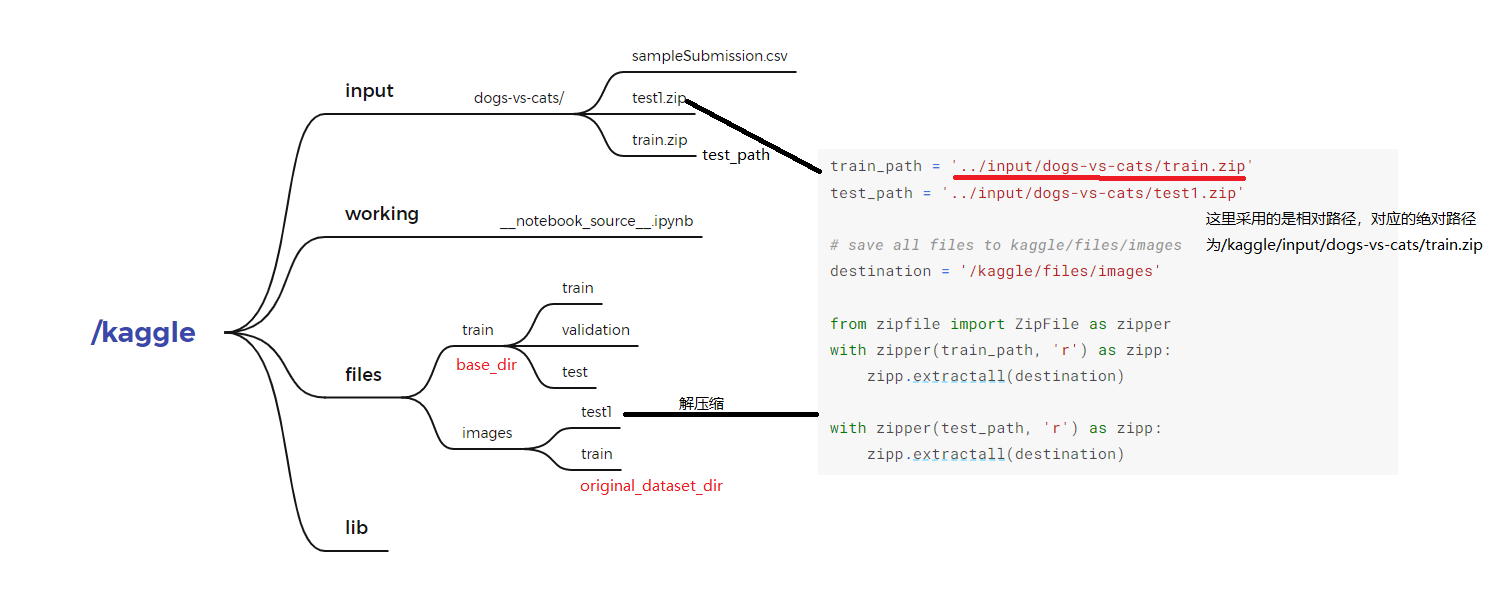

In [ ]:
import os, shutil

original_dataset_dir = '/kaggle/files/images/train'
base_dir = '/kaggle/files/train'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

# 3、构建网络    
**将猫狗分类的小型卷积神经网络实例化**

In [ ]:
from tensorflow.keras import models, layers


#with tpu_strategy.scope():
network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(64, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Flatten())
network.add(layers.Dense(512, activation = 'relu'))
network.add(layers.Dense(1, activation = 'sigmoid'))

绘制构建的网络

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(network, show_shapes = True, to_file = 'cats and dogs.png')

查看模型中的参数

In [ ]:
network.summary()

# 4、配置模型用于训练(优化器、损失函数、度量)

In [ ]:
from tensorflow import optimizers

network.compile(loss = 'binary_crossentropy', 
               optimizer = optimizers.RMSprop(learning_rate = 1e-4),
               metrics = ['accuracy'])

# 5、数据预处理(datagen data_generator)  
  (1) 读取图像文件  
  (2) 将JPEG文件解码为RGB像素网格  
  (3) 将这些像素网格转换为浮点张量  
  (4) 将这些像素值缩放到[0, 1]区间  

ImageDataGenerator使用实时数据增强来生成批量图像的数据

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0 / 255)
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), 
                                                    batch_size = 20, class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size = (150, 150),
                                                    batch_size = 20, class_mode = 'binary')

# 6、利用批量生成器拟合模型

In [ ]:
history = network.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)

# 7、保存模型

In [ ]:
network.save('cats_and_dogs_small_1.h5')

# 8、绘制训练过程中的损失曲线和精度曲线

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'ro')
plt.plot(epochs, val_loss, 'r', label = "Validating Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Traing Loss and Validating Loss")

plt.legend()
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, accuracy, 'b', label = "Training Accuracy")

plt.plot(epochs, val_accuracy, 'ro')
plt.plot(epochs, val_accuracy, 'r', label = "Validating Accuracy")

plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
max(val_accuracy)

# 二、使用数据增强

1、定义一个包含dropout的新卷积神经网络

In [ ]:
import tensorflow as tf    
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():
#     model = tf.keras.Sequential( … ) # define your model normally
#     model.compile( … )

# train model normally
# model.fit(training_dataset, epochs=EPOCHS, steps_per_epoch=…)

In [ ]:
from tensorflow.keras import models, layers


#with tpu_strategy.scope():
network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Conv2D(64, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2,2))
network.add(layers.Flatten())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(512, activation = 'relu'))
network.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(network, show_shapes = True)

In [ ]:
network.summary()

编译网络模型

In [ ]:
from tensorflow.keras import optimizers

network.compile(optimizer = optimizers.RMSprop(learning_rate = 1e-4), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

使用数据增强(在训练集上做数据增强，测试集上不需要)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range = 40, 
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = 0.2)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150 ,150), batch_size = 20, class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_dir ,target_size = (150, 150), batch_size = 20, class_mode = 'binary')

In [ ]:
history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 100, validation_data = validation_generator, validation_steps = 50)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'ro')
plt.plot(epochs, val_loss, 'r', label = "Validating Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Traing Loss and Validating Loss")

plt.legend()
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'bo')
plt.plot(epochs, accuracy, 'b', label = "Training Accuracy")

plt.plot(epochs, val_accuracy, 'ro')
plt.plot(epochs, val_accuracy, 'r', label = "Validating Accuracy")

plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [ ]:
max(val_accuracy)

# 三、使用预训练的卷积神经网络

1、将VGG16卷积实例化

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

绘制网络结构

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(conv_base, show_shapes = True)

查看网络中的参数

In [ ]:
conv_base.summary()

## （一）不使用数据增强的特征提取  
在数据集上运行卷积基，将输出保存成Numpy数组，然后用这个数据作为输入，将输入连接到密集连接分类器中

1、使用预训练的卷积基提取特征

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/kaggle/files/train'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1.0 / 255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size, 
        class_mode = 'binary')
    
    i = 0
    for input_batch, label_batch in generator:
        feature_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = feature_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features ,validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

2、定义并训练密集连接分类器

In [ ]:
from keras import models, layers
from tensorflow import optimizers

network = models.Sequential()
network.add(layers.Dense(256, activation = 'relu', input_shape = (4 * 4* 512, )))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(1, activation = 'sigmoid'))

network.compile(optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [ ]:
history = network.fit(train_features, train_labels, epochs = 30, batch_size = 20, validation_data = (validation_features, validation_labels))

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Traing Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
print(f"minmum validation loss:{min(val_loss)}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validating Accuracy')
plt.title('Traing Accuracy and Validating Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print(f"maximum validation accuracy :{max(val_acc)}")

# (二)使用数据增强的特征提取

In [ ]:
from keras import models, layers

network = models.Sequential()
network.add(conv_base)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation = 'relu'))
network.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
network.summary()

冻结卷积基

In [ ]:
conv_base.trainable = False

In [ ]:
network.summary()

利用冻结的卷积基训练端到端的模型

In [ ]:
from tensorflow import optimizers
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                              rotation_range = 40, 
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              shear_range = 0.2,
                              zoom_range = 0.2, 
                              horizontal_flip = True,
                              fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size = (150, 150), batch_size = 20, class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')

In [ ]:
network.compile(optimizer = optimizers.RMSprop(learning_rate = 2e-5),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [ ]:
history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30, 
                                validation_data = validation_generator, validation_steps = 50)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Traing Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
print(f"minmum validation loss:{min(val_loss)}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validating Accuracy')
plt.title('Traing Accuracy and Validating Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
print(f"maximum validation accuracy :{max(val_acc)}")

# （三）、模型微调

将模型最上面的几层和新增加的部分联合训练（全连接分类器）

## 微调模型的步骤如下：
（1）在已训练好的基网络(base network)上添加自定义网络  
（2）冻结基网络  
（3）训练所添加的部分  
（4）解冻基网络的一些层  
（5）联合训练解冻的这些层和添加的部分

In [ ]:
conv_base.summary()

1、冻结直到某一层的所有层

In [ ]:
conv_base.trainable = True

set_trainable = True
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

2、微调模型  
只有模型重新编译之后，上述解冻才能生效

In [ ]:
from tensorflow import optimizers

network.compile(optimizer = optimizers.RMSprop(learning_rate = 1e-5),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

history = network.fit_generator(train_generator, steps_per_epoch = 100, epochs = 30, 
                                validation_data = validation_generator, validation_steps = 50)

3、绘制结果

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = 'Training Loss')
plt.plot(epochs, val_loss, 'orange', label = 'Validating Loss')
plt.title('Traing Loss and Validating Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validating Accuracy')
plt.title('Traing Accuracy and Validating Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
max(val_acc)

3、在验证集上评估模型

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')

test_loss, test_acc = network.evaluate_generator(test_generator, steps = 50)

print(f"test_loss: {test_loss}")
print(f"test_acc:{test_acc}")